In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2

from trasim_simplified.core.kinematics.cfm import get_cf_func
from trasim_simplified.core.constant import CFM

dt = 0.1
cf_name = CFM.IDM
cf_func = get_cf_func(cf_name)
param_names = ["s0", "v0", "T", "omega", "d", "delta"]
# param_names = ["k1", "k2", "thw", "s0"]

In [2]:
from trasim_simplified.util.tools import load_from_pickle, save_to_pickle
from trasim_simplified.core.constant import TrackInfo as TI, Prefix
import numpy as np

clb_type = "full"

# 读取轨迹
traj_s_full_ori: dict[str, dict] = load_from_pickle(r"E:\PyProject\car-following-model-test\tests\data\ori_full_traj_s.pkl")
# 去除NaN轨迹对
invalid_pairs = np.load(r"E:\PyProject\car-following-model-test\tests\data\invalid_ids.npy")
traj_s_full_ori["dec"] = {k: v for k, v in traj_s_full_ori["dec"].items() if k not in invalid_pairs}
traj_s_full_ori["acc"] = {k: v for k, v in traj_s_full_ori["acc"].items() if k not in invalid_pairs}

save_to_pickle(traj_s_full_ori, r"E:\PyProject\car-following-model-test\tests\data\ori_full_traj_s.pkl")

traj_s_cut_pos = {pair_id: len(df_pair) for pair_id, df_pair in traj_s_full_ori["dec"].items()}

if clb_type == "full":
    traj_s_full: dict[str, pd.DataFrame] = {pair_id: pd.concat([df_pair, traj_s_full_ori["acc"][pair_id]]) for pair_id, df_pair in traj_s_full_ori["dec"].items()}
elif clb_type == "dec":
    traj_s_full: dict[str, pd.DataFrame] = traj_s_full_ori["dec"]
elif clb_type == "acc":
    traj_s_full: dict[str, pd.DataFrame] = traj_s_full_ori["acc"]
else:
    raise ValueError(f"clb_type: {clb_type} is not supported!")

obs_x_s = [traj_s_full[k][TI.x] for k in traj_s_full.keys()]
obs_v_s = [traj_s_full[k][TI.v] for k in traj_s_full.keys()]
obs_lx_s = [traj_s_full[k][Prefix.leader + TI.x] for k in traj_s_full.keys()]
obs_lv_s = [traj_s_full[k][Prefix.leader + TI.v] for k in traj_s_full.keys()]
leaderL_s = [traj_s_full[k][Prefix.leader + TI.v_Length].unique()[0] for k in traj_s_full.keys()]
id_s = [k for k in traj_s_full.keys()]
print(len(id_s))

690


In [3]:
from trasim_simplified.util.calibrate.clb_cf_model import clb_run

# 跟驰模型参数标定
results = clb_run(
    cf_func=cf_func, cf_name=cf_name,
    obs_x_s=obs_x_s, obs_v_s=obs_v_s, obs_lx_s=obs_lx_s, obs_lv_s=obs_lv_s, leaderL_s=leaderL_s,
    dt=0.1, seed=2024, drawing=0, n_jobs=4,
    cf_param_ranges_=None
)

Using geatpy


100%|██████████| 690/690 [14:46<00:00,  1.28s/it]


In [5]:
from trasim_simplified.util.calibrate.clb_cf_model import aggregate_result

avg_obj, avg_param, std_obj, std_param = aggregate_result(results)
print(f"avg_obj: {avg_obj}\navg_param: {avg_param}\nstd_obj: {std_obj}\nstd_param: {std_param}")

avg_obj: 0.7230800807041379
avg_param: [ 4.46822351 22.98656679  0.97528816  2.50608892  5.52303302  6.47971014]
std_obj: 0.4412320415434251
std_param: [ 2.58233578 11.69034305  0.56549775  2.12721417  4.03599354  3.48957369]


In [6]:
from trasim_simplified.util.calibrate.clb_cf_model import clb_param_to_df

param_df = clb_param_to_df(id_s, results, cf_name)

if clb_type == "full":
    param_df.to_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_full_param_df" + f"_{cf_name}.pkl")
elif clb_type == "dec":
    param_df.to_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_dec_param_df" + f"_{cf_name}.pkl")
elif clb_type == "acc":
    param_df.to_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_acc_param_df" + f"_{cf_name}.pkl")
else:
    raise ValueError(f"clb_type: {clb_type} is not supported!")
param_df

,s0,v0,T,omega,d,delta,Pair_ID,ObjV
0,10.000000,40.000000,0.436868,0.548210,10.000000,10.0,10,0.863981
1,7.737167,24.353724,0.476107,1.981402,2.087164,4.0,12,0.576711
2,10.000000,40.000000,1.109293,0.605000,0.407477,10.0,14,1.388066
3,6.811732,17.958565,0.733120,2.752649,10.000000,7.0,15,0.543265
4,0.100000,17.043753,0.805630,1.015823,9.997592,6.0,17,0.668795
...,...,...,...,...,...,...,...,...
685,5.767894,10.000000,0.379805,1.382309,9.999943,2.0,6569,0.641105
686,10.000000,40.000000,0.525731,0.771206,10.000000,10.0,6597,1.838980
687,5.596684,10.007324,0.590291,1.280191,3.240674,4.0,6599,0.277605
688,2.435371,25.120707,2.259007,1.832077,0.513617,2.0,6603,0.952197


In [7]:
if clb_type == "full":
    param_df = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_full_param_df" + f"_{cf_name}.pkl")
elif clb_type == "dec":
    param_df = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_dec_param_df" + f"_{cf_name}.pkl")
elif clb_type == "acc":
    param_df = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_acc_param_df" + f"_{cf_name}.pkl")
else:
    raise ValueError(f"clb_type: {clb_type} is not supported!")
param_df

,s0,v0,T,omega,d,delta,Pair_ID,ObjV
0,10.000000,40.000000,0.436868,0.548210,10.000000,10.0,10,0.863981
1,7.737167,24.353724,0.476107,1.981402,2.087164,4.0,12,0.576711
2,10.000000,40.000000,1.109293,0.605000,0.407477,10.0,14,1.388066
3,6.811732,17.958565,0.733120,2.752649,10.000000,7.0,15,0.543265
4,0.100000,17.043753,0.805630,1.015823,9.997592,6.0,17,0.668795
...,...,...,...,...,...,...,...,...
685,5.767894,10.000000,0.379805,1.382309,9.999943,2.0,6569,0.641105
686,10.000000,40.000000,0.525731,0.771206,10.000000,10.0,6597,1.838980
687,5.596684,10.007324,0.590291,1.280191,3.240674,4.0,6599,0.277605
688,2.435371,25.120707,2.259007,1.832077,0.513617,2.0,6603,0.952197


In [8]:
pd.options.display.precision = 2

param_df[param_names + ["ObjV"]].describe().loc[["mean", "std", "min", "max"]]

,s0,v0,T,omega,d,delta,ObjV
mean,4.47,22.99,0.98,2.51,5.52,6.48,0.72
std,2.58,11.70,0.57,2.13,4.04,3.49,0.44
min,0.10,10.00,0.10,0.42,0.10,1.00,0.07
max,10.00,40.00,3.33,10.00,10.00,10.00,3.13


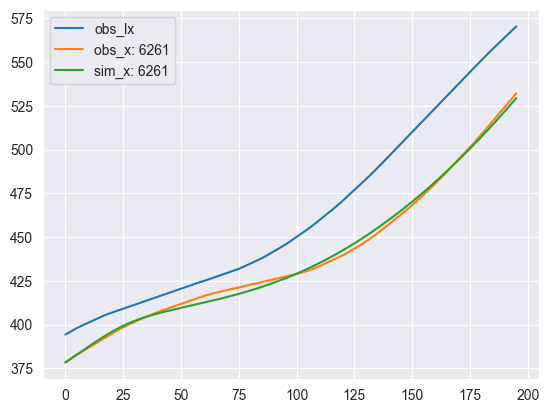

In [9]:
from trasim_simplified.util.calibrate.clb_cf_model import show_traj
import random
import numpy as np

pos = random.choice(range(len(id_s)))
id_ = id_s[pos]
# id_ = 5283
pos = np.where(np.array(id_s) == id_)[0][0]

# pos = param_df[param_df[TI.Pair_ID] == 2778].index[0]

target = param_df[param_df[TI.Pair_ID] == id_]
obs_x = obs_x_s[pos]
obs_v = obs_v_s[pos]
obs_lx = obs_lx_s[pos]
obs_lv = obs_lv_s[pos]
leaderL = leaderL_s[pos]
show_traj(cf_name, target.to_numpy().reshape(-1), dt, obs_x, obs_v, obs_lx, obs_lv, leaderL, traj_step=None, pair_ID=id_)

In [10]:
from trasim_simplified.util.tools import save_to_pickle
from trasim_simplified.util.calibrate.clb_cf_model import get_clb_traj

traj_s_full_: dict[str, pd.DataFrame] = {pair_id: pd.concat([df_pair, traj_s_full_ori["acc"][pair_id]]) for pair_id, df_pair in traj_s_full_ori["dec"].items()}

clb_traj_s = get_clb_traj(traj_s_full_, traj_s_cut_pos, param_df, cf_func, cf_name, dt)

if clb_type == "full":
    save_to_pickle(clb_traj_s,
               r"E:\PyProject\car-following-model-test\tests\data\clb_full_traj_s" + f"_{cf_name}.pkl")
elif clb_type == "dec":
    save_to_pickle(clb_traj_s,
               r"E:\PyProject\car-following-model-test\tests\data\clb_dec_traj_s" + f"_{cf_name}.pkl")
    print(len(clb_traj_s["acc"]))
elif clb_type == "acc":
    save_to_pickle(clb_traj_s,
               r"E:\PyProject\car-following-model-test\tests\data\clb_acc_traj_s" + f"_{cf_name}.pkl")
else:
    raise ValueError(f"clb_type: {clb_type} is not supported!")